## New experiments

In [ ]:
!pip install numpy matplotlib scipy scikit-learn seaborn pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
from scipy.stats import norm

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons, make_circles

In [ ]:
def visualize_GAN(gan, real_data):
    num = 500
    real_data = pd.DataFrame(real_data, columns=['x', 'y'])
    samples = pd.DataFrame(gan.sample(num), columns=['x', 'y'])
    
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    sns.kdeplot(real_data, x='x', y='y', fill=True, ax=axs[0])
    sns.kdeplot(samples, x='x', y='y', fill=True, color='r', ax=axs[1])
    plt.show()

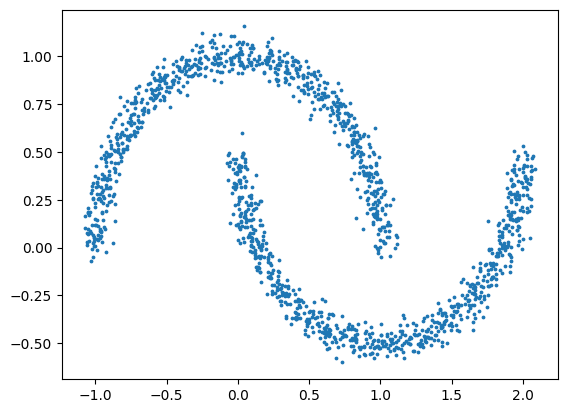

In [ ]:
moons = torch.tensor(make_moons(1500, noise=0.05)[0], dtype=torch.float32)
plt.scatter(moons[:, 0], moons[:, 1], s=3)
plt.show()

In [ ]:
class GAN():
    def __init__(self, n_latent=2, device='cpu'):
        self.gen = self._get_simple_model([n_latent, 32, 32, 32, 2]).to(device)
        self.disc = nn.Sequential(*self._get_simple_model([2, 32, 32, 32, 1], True), nn.Sigmoid()).to(device)
        self.noise_fn = lambda num: torch.normal(0, 1, size=(num, self.n_latent), device=device)

        self.n_latent = n_latent
        self.device = device
        
    def sample(self, num=1000):
        latent_vec = self.noise_fn(num)
        with torch.no_grad():
            samples = self.gen(latent_vec)
        return samples.cpu().numpy()

    def _get_simple_model(self, hiddens, disc=False):
        assert len(hiddens) > 1
        activation = nn.LeakyReLU() if disc else nn.ReLU()
        modules = []
        for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
            modules.extend([nn.Linear(in_, out_),nn.BatchNorm1d(out_), nn.ReLU()])
        modules.append(nn.Linear(hiddens[-2], hiddens[-1]))
        return nn.Sequential(*modules)

In [ ]:
class GANTrainer():
    def __init__(self, model, batch_size=32, lr_disc=1e-3, lr_gen=2e-4):
        self.model = model
        self.batch_size = batch_size
        self.device = model.device
        self.criterion = nn.BCELoss()
        self.optim_disc = torch.optim.Adam(model.disc.parameters(), lr=lr_disc)
        self.optim_gen = torch.optim.Adam(model.gen.parameters(), lr=lr_gen)

    def _train_step_gen(self):
        """Train the generator one step and return the loss."""
        self.model.gen.zero_grad()
        
        latent_vec = self.model.noise_fn(self.batch_size)
        generated = self.model.gen(latent_vec)
        classifications = self.model.disc(generated)
        loss = self.criterion(classifications, torch.ones((self.batch_size, 1)).to(self.device))
        
        loss.backward()
        self.optim_gen.step()
        return loss.item()

    def _train_step_disc(self, real_data):
        """Train the discriminator one step and return the losses."""
        self.model.disc.zero_grad()

        pred_real = self.model.disc(real_data)
        loss_real = self.criterion(pred_real, torch.ones((self.batch_size, 1)).to(self.device))

        latent_vec = self.model.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.model.gen(latent_vec)
        pred_fake = self.model.disc(fake_samples)
        loss_fake = self.criterion(pred_fake, torch.zeros((self.batch_size, 1)).to(self.device))

        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_disc.step()
        
        return loss_real.item(), loss_fake.item()

    def _train_step(self, real_data):
        """Train both networks and return the losses."""
        loss_disc = self._train_step_disc(real_data)
        loss_gen = self._train_step_gen()
        return loss_gen, loss_disc

    def train(self, epochs, dataloader):
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}
        for epoch in tqdm(range(epochs)):
            avg_loss_gen = 0
            avg_loss_disc_real = 0
            avg_loss_disc_fake = 0
            # for batch in tqdm(dataloader):
            for batch in dataloader:
                self.batch_size = batch.shape[0]
                loss_gen, (loss_disc_real, loss_disc_fake) = self._train_step(batch.to(self.device))
                avg_loss_gen += loss_gen
                avg_loss_disc_real += loss_disc_real
                avg_loss_disc_fake += loss_disc_fake
            losses['loss_gen'].append(avg_loss_gen / len(dataloader))
            losses['loss_disc_real'].append(avg_loss_disc_real / len(dataloader))
            losses['loss_disc_fake'].append(avg_loss_disc_fake / len(dataloader))
            # print(f'gen Loss: {losses["loss_gen"][-1]}, disc Real Loss: {losses["loss_disc_real"][-1]}, disc Fake Loss: {losses["loss_disc_fake"][-1]}')
            # visualize_GAN(self.model, moons)
        return losses

In [ ]:
BATCH_SIZE = 32
EPOCHS = 200
LR_D = 1e-4
LR_G = 3e-5
N_LATENS = 2

dataloader = DataLoader(moons, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

gan = GAN(N_LATENS, device='cuda')

trainer = GANTrainer(gan, batch_size=BATCH_SIZE, lr_disc=LR_D, lr_gen=LR_G)
losses = trainer.train(EPOCHS, dataloader)

  0%|          | 0/200 [00:00<?, ?it/s]

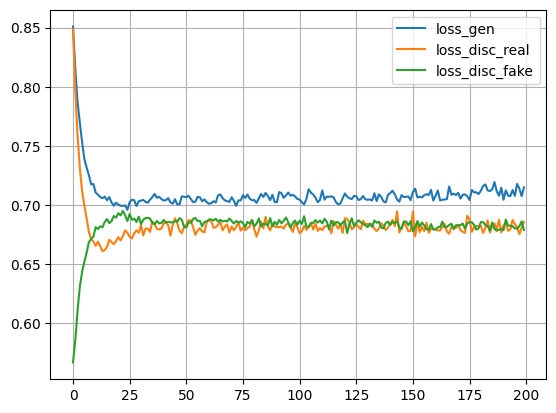

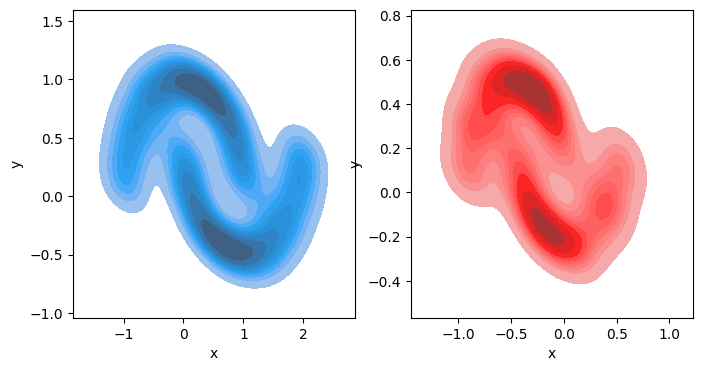

In [ ]:
plt.figure()
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
visualize_GAN(gan, moons)

## CycleGAN

In [ ]:
def visualize_CycleGAN(gan_x, gan_y, x, y):
    num = 500
    fake_x = pd.DataFrame(gan_x.gen(y.cuda()).cpu().detach().numpy(), columns=['x', 'y'])
    fake_y = pd.DataFrame(gan_y.gen(x.cuda()).cpu().detach().numpy(), columns=['x', 'y'])
    x = pd.DataFrame(x, columns=['x', 'y'])
    y = pd.DataFrame(y, columns=['x', 'y'])
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 4))
    sns.kdeplot(x, x='x', y='y', fill=True, ax=axs[0][0])
    sns.kdeplot(fake_x, x='x', y='y', fill=True, color='r', ax=axs[0][1])
    sns.kdeplot(y, x='x', y='y', fill=True, ax=axs[1][0])
    sns.kdeplot(fake_y, x='x', y='y', fill=True, color='r', ax=axs[1][1])
    plt.show()

In [ ]:
class MoonCircleDataset(Dataset):
    def __init__(self, size):
        self.size = size
        self.circles = torch.tensor(make_circles(size, noise=0.05, factor=0.5)[0], dtype=torch.float32)
        self.moons = torch.tensor(make_moons(size, noise=0.05)[0], dtype=torch.float32)

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):        
        return self.circles[idx], self.moons[idx]

In [ ]:
class CycleGANTrainer():
    def __init__(self, gan_x, gan_y, lr_disc=1e-3, lr_gen=2e-4):
        self.gan_x = gan_x
        self.gan_y = gan_y
        self.device = gan_x.device
        self.criterion = nn.BCELoss()
        self.cycle_criterion = nn.MSELoss()
        self.optim_disc = torch.optim.Adam([{'params': gan_x.disc.parameters()},
                                            {'params': gan_y.disc.parameters()}], lr=lr_disc)
        # self.optim_disc_y = torch.optim.Adam(gan_y.disc.parameters(), lr=lr_disc)
        self.optim_gen = torch.optim.Adam([{'params': gan_x.gen.parameters()},
                                           {'params': gan_y.gen.parameters()}], lr=lr_gen)

    def _init_scheduler(self, epochs):
        lambda_func = lambda epoch: 1 - max(0, epoch - 20) / epochs
        self.lr_scheduler_disc = torch.optim.lr_scheduler.LambdaLR(self.optim_disc, lr_lambda=lambda_func)
        self.lr_scheduler_gen = torch.optim.lr_scheduler.LambdaLR(self.optim_gen, lr_lambda=lambda_func)

    def _train_step_gen(self, x, y):
        """Train the generator one step and return the loss."""
        self.gan_x.gen.zero_grad()
        self.gan_y.gen.zero_grad()
        
        fake_x = self.gan_x.gen(y)
        fake_y = self.gan_y.gen(x)

        loss_identity_x = self.cycle_criterion(fake_y, x)
        loss_identity_y = self.cycle_criterion(fake_x, y)
        loss_identity = (loss_identity_x + loss_identity_y) / 2                        
        
        cls_x = self.gan_x.disc(fake_x)
        cls_y = self.gan_y.disc(fake_y)
        loss_gan_x = self.criterion(cls_x, torch.ones((self.batch_size, 1)).to(self.device))
        loss_gan_y = self.criterion(cls_y, torch.ones((self.batch_size, 1)).to(self.device))
        loss_gan = (loss_gan_x + loss_gan_y) / 2

        recov_x = self.gan_x.gen(fake_y)
        recov_y = self.gan_y.gen(fake_x)
        loss_cycle_x = self.cycle_criterion(recov_x, x)
        loss_cycle_y = self.cycle_criterion(recov_y, y)
        loss_cycle = (loss_cycle_x + loss_cycle_y) / 2

        loss = loss_gan + 10*loss_cycle + 5*loss_identity
        loss.backward()
        self.optim_gen.step()
        self.lr_scheduler_gen.step()
        return loss.item()

    def _train_step_disc(self, x, y):
        """Train the discriminator one step and return the losses."""
        self.gan_x.disc.zero_grad()
        self.gan_y.disc.zero_grad()
        
        cls_x = self.gan_x.disc(x)
        cls_y = self.gan_y.disc(y)
        loss_real_x = self.criterion(cls_x, torch.ones((self.batch_size, 1)).to(self.device))
        loss_real_y = self.criterion(cls_y, torch.ones((self.batch_size, 1)).to(self.device))
        loss_real = (loss_real_x + loss_real_y) / 2

        with torch.no_grad():
            fake_x = self.gan_x.gen(y)
            fake_y = self.gan_y.gen(x)
        cls_fake_x = self.gan_x.disc(fake_x)
        cls_fake_y = self.gan_y.disc(fake_y)
        loss_fake_x = self.criterion(cls_fake_x, torch.zeros((self.batch_size, 1)).to(self.device))
        loss_fake_y = self.criterion(cls_fake_y, torch.zeros((self.batch_size, 1)).to(self.device))
        loss_fake = (loss_fake_x + loss_fake_y) / 2
        
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_disc.step()
        self.lr_scheduler_disc.step()
        return loss_real.item(), loss_fake.item()

    def _train_step(self, x, y):
        """Train both networks and return the losses."""
        loss_disc = self._train_step_disc(x, y)
        loss_gen = self._train_step_gen(x, y)
        return loss_gen, loss_disc

    def train(self, epochs, dataloader):
        self._init_scheduler(epochs * len(dataloader))
        losses = {'loss_gen': [], 'loss_disc_real': [], 'loss_disc_fake': []}
        for epoch in tqdm(range(epochs)):
            avg_loss_gen = 0
            avg_loss_disc_real = 0
            avg_loss_disc_fake = 0
            # for batch in tqdm(dataloader):
            for x, y in dataloader:
                self.batch_size = x.shape[0]
                loss_gen, (loss_disc_real, loss_disc_fake) = self._train_step(x.to(self.device), y.to(self.device))
                avg_loss_gen += loss_gen
                avg_loss_disc_real += loss_disc_real
                avg_loss_disc_fake += loss_disc_fake
            losses['loss_gen'].append(avg_loss_gen / len(dataloader))
            losses['loss_disc_real'].append(avg_loss_disc_real / len(dataloader))
            losses['loss_disc_fake'].append(avg_loss_disc_fake / len(dataloader))
            # print(f'gen Loss: {losses["loss_gen"][-1]}, disc Real Loss: {losses["loss_disc_real"][-1]}, disc Fake Loss: {losses["loss_disc_fake"][-1]}')
            # visualize_GAN(self.model, moons)
        return losses

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
LR_D = 1e-3
LR_G = 1e-3

dataset = MoonCircleDataset(10_000)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

gan_x = GAN(device='cuda')
gan_y = GAN(device='cuda')

trainer = CycleGANTrainer(gan_x, gan_y, lr_disc=LR_D, lr_gen=LR_G)
losses = trainer.train(EPOCHS, dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

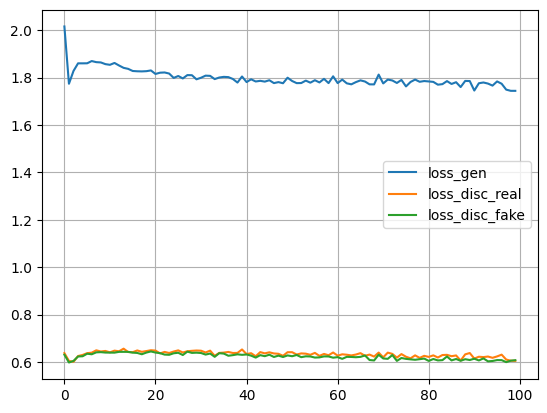

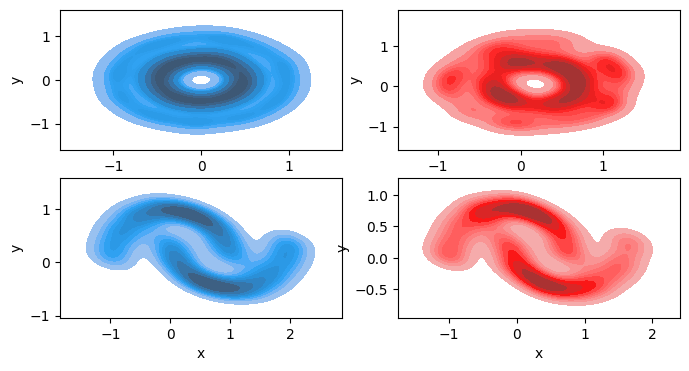

In [ ]:
plt.figure()
for key, value in losses.items():
    plt.plot(range(len(value)), value, label=key)
plt.grid()
plt.legend()
plt.show()
visualize_CycleGAN(gan_x, gan_y, circles, moons)